* tau: `the length of the impulse response in samples', so tau_ms must be length in ms. But how do we know this? Also how does this definition of tau tally with the window size (see below)? - Update: when we slice trials into slices of length tau, 
* evtlabs
* ofs
* rank
* stim2event(Y, axis=-2, evtypes) converts (n_trial, n_samp, nY+1) -> (n_trial, n_samp, nY+1, len(evtypes))
* updateCxy produces (nY, len(evtypes), tau, n_chan), i.e. for each obj, evtype, chan, and length-tau slice, sum over tau samples in all trials. It makes use of window_axis which slices up X along the samp axis, into slices of tau samples, with a slide step size of 1 samp
* updateCxx produces (tau, n_chan, tau, n_chan), i.e. the covariance of each pair of (length-tau slice, chan) pairs
* multipleCCA produces W (rank, n_chan) and R (rank, len(evtypes), tau)

* cv_fit method of the classifier makes predictions on the held-out examples in each fold so that we get predictions of each example in the whole dataset based on an appropriate train split that excludes it. So, basically we don't need to do additional prediction on a separate test dataset. Having said that, we will need to do something custom if we want to see accuracy changes as the number of training trials increases.
* "Epoched" = sliced into length tau slices
* In cv_fit, in each fold, we train and then predict. Predict calls scoreStimulus and then scoreOuptut. 
 - scoreStimulus is called on 3-dim X, and so it in turn calls scoreStimulusCont (as opposed to scoreStimulusEpoch). This first calls factored2full(W, R), which "converts a factored spatio-temporal model to a full model". In working out what this means we also reveal clues for the meanings of some other mysterious terminology like "forward" and "backward" model. Apparently, the former is R and latter is W, so they are referring to the projection of stimulus onto the common space as "forward" etc. factored2full seems to expand the dims of W and R to each have a singleton zeroth dimension, and then performs via einsum an outer product of W and R -> (1, len(evtypes), tau, n_chan) summing over the 'rank' of the CCA, i.e. over the CCA components considered (often just 1), so this takes a spatial filter (W) and a temporal feature (R) and produces a single spatio-temporal filter (per event type), at the same time summing over CCA components if appropriate. 
 - Back to scoreStimulusCont, we next call window_axis using the tau value extracted from R (i.e. the one that was passed in and first used to slice X), to slice X exactly as was done in updateCxx etc. Then we pass this sliced X (Xe) along with the S-T filter (now called W) to scoreStimulusEpoch. Also note before we move onto the latter, that if X has fewer samples (n_samp dimension) than tau, then a score of 0 is returned instead of calling scoreStimulusEpoch, since we don't have enough samples from the response to a stimulus to score it. 
 - scoreStimulusEpoch, due to the way it is called (R = None) redirects to scoreStimulusEpoch_full, which finally applies the filter to the epoched data. It performs an einsum inner product over the tau and channel dimensions of X and W, producing a (m(=1), n_trials, n_epochs(=n_samp - tau), len(evtypes)) ndarray. So this is a per-epoch-per-trial, per-evtype score.
 - We then pass the result of scoreSimulus ('Fe') and Ye (the output of stim2event(Y)) to scoreOutput. This simply performs an inner product between Fe and Ye over the event types, i.e. sums the per-event-type scores of Fe according to which event types were present in each object's stimulus sequence during a particular epoch within a particular trial.
* After all folds are done, we retrain with all the train data, and then estimate sigma0 (some sort of "prior"?) via estimate_Fy_noise_variance, and possibly calibrate the softmax scale.
* Then next thing done in analyse_dataset is to call decodingCurveSupervised using the trained model's sigma0 and its "priorweight", which is bafflingly just hard-coded to 120!
* What, then, does decodingCurveSupervised do? Well that's hard to tell...
 - It grids up (along epochs) the Fy scores for each trial into 25 "integrationLengths" and for each one calls decodingSupervised on Fy indexed from the start up until that integration length, i.e. each time it is called on more of Fy. But what does decodingSupervised do...?
 - It first calls normalizeOutputScores which is a nightmare so we'll return to that
 - Then it computes the probabilities for each output (class) for each trial using zscore2Ptgt_softmax
 
Pick up: I'm going through debug_test_dataset in analyse_datasets.py, which has led me into UpdateSummaryStatistics.py. I don't know how we're supposed to know tau. Ah! tau seems to be being used as the window size in UpdateSum... check out the func window_axis from utils

Overall I'm trying to work out if debug_test_... already handles some sort of cv with a train and test split, or if it just uses all data as train. So far I've only loaded the thielen train dataset, and not the test...

Monday 12th Oct: Now I need to take a deeper look at scoreStimulus and scoreOutput to see how we produces Fe and Fy

Example offline analysis of savefile
--
This notebook shows how to do a quick post-hoc analysis of a test run using the  mindaffectBCI Makers-Kit.

## Take the .mat data from the Thielen study and apply cca model
### Then work out what sort of accumulation (accuracy improvement) happens in the decoding curve, and compare with accuracy improvement as we use more calibration data

In [2]:
import numpy as np
from analyse_datasets import debug_test_dataset, analyse_dataset, analyse_datasets
from offline.load_mindaffectBCI  import load_mindaffectBCI
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

In [20]:
d = loadmat('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/train/converted_360_2_48.mat')

In [27]:
ofs = d['resamplefs']

ofs[0][0]

360

In [31]:
a = np.asarray(360)
a = a.astype('uint8')
a

array(104, dtype=uint8)

In [66]:
(1,)* 3

(1, 1, 1)

In [68]:
from mindaffectBCI.decoder.utils import window_axis
a = np.random.rand(2, 10, 3)
print(a.shape)
print(a)
aa = window_axis(a, 4, -2)
print(aa.shape)
print(aa)


(2, 10, 3)
[[[0.34166908 0.46473469 0.41220738]
  [0.39516167 0.92231478 0.2493    ]
  [0.94055091 0.23853762 0.59818119]
  [0.00285268 0.9508983  0.37201008]
  [0.38058637 0.40753665 0.61704393]
  [0.00794844 0.63335071 0.7689605 ]
  [0.79970981 0.56416968 0.75981067]
  [0.66235571 0.80350203 0.894529  ]
  [0.03495961 0.08894989 0.80464737]
  [0.48657834 0.949077   0.04853904]]

 [[0.08161096 0.42653166 0.31983539]
  [0.67683877 0.16847711 0.29732533]
  [0.3650096  0.36187802 0.45302573]
  [0.52489225 0.72327783 0.49302868]
  [0.20467054 0.31002058 0.98472819]
  [0.86352866 0.05928356 0.74277118]
  [0.93725058 0.63362019 0.44117707]
  [0.20094164 0.99364798 0.81105845]
  [0.42167626 0.720555   0.26857408]
  [0.01000768 0.53330567 0.0784745 ]]]
(2, 7, 4, 3)
[[[[0.34166908 0.46473469 0.41220738]
   [0.39516167 0.92231478 0.2493    ]
   [0.94055091 0.23853762 0.59818119]
   [0.00285268 0.9508983  0.37201008]]

  [[0.39516167 0.92231478 0.2493    ]
   [0.94055091 0.23853762 0.59818119]
  

In [17]:
import sys
np.set_printoptions(threshold=sys.maxsize)
codes = d['codes']
codes = codes.astype('bool')
X = d['data']
print(codes.shape)
print(codes[0,:])
codes = codes[np.mod(np.arange(0, X.shape[1]), codes.shape[0]), :]
print(codes.shape)
print(codes[126,:])

(126, 36)
[ True False False False False False False  True False  True False False
 False  True  True  True False False  True  True False False False  True
 False False  True  True  True  True  True False False False False  True]
(1513, 36)
[ True False False False False False False  True False  True False False
 False  True  True  True False False  True  True False False False  True
 False False  True  True  True  True  True False False False False  True]


In [19]:
X.ndim

3

In [45]:
def load_thielen_train(data_mat_path):
    """
    Carries out no additional preprocessing (e.g. filtering, resampling) - assumes this has
    already been performed
    """
    d = loadmat(data_mat_path)
    ofs = d['resamplefs'][0][0]  # sample rate after downsampling
    X = d['data']
    X = X.astype("float32")  # (n_chan, n_samp, n_trial) raw eeg
    X = np.moveaxis(X, (0, 1, 2), (2, 1, 0))  # (n_trial, n_samp, n_chan)
    X = np.ascontiguousarray(X)  # ensure memory-efficient layout
    
    labels = d['labels']  # (n_trial, 1)  # NB n_trial = nY in this Thielen data
    labels = labels.astype('uint8').ravel()
    
    codes = d['codes']  # (code_length, nY) where nY is number of codes (i.e. objects)
    codes = codes.astype('bool')
    
    # convert labels + code into Y + samp-times,  where 1st row is always the true label
    # loop codes up to X size (NB this assumes n_trial = nY, which it does for this data)
    codes = codes[np.mod(np.arange(0, X.shape[1]), codes.shape[0]), :]  # (n_samp, nY)
    Y = np.zeros((len(labels), X.shape[1], codes.shape[1]+1), dtype=bool) # (n_trial, n_samp, nY+1)
    for ti, lab in enumerate(labels):
        Y[ti, :, 0] = codes[:, lab - 1]  # copy in true label
        Y[ti, :, 1:] = codes # copy in other outputs
        
    # make coords array fro the meta-info about the dimensions of X
    coords = [None] * X.ndim
    coords[0] = {'name': 'trial'}
    coords[1] = {'name': 'time',
                 'unit': 'ms',
                 'coords': np.arange(X.shape[1]) * 1000 / ofs,
                 'fs': ofs}
    coords[2] = {'name': 'channel',
                 'coords': None}
    
    return (X, Y, coords)
        
    

In [58]:
a = np.arange(3)
b = np.arange(4)
ab = np.einsum("i, j->ij", a, b)
print(a)
print(b)
print(ab)

[0 1 2]
[0 1 2 3]
[[0 0 0 0]
 [0 1 2 3]
 [0 2 4 6]]


In [57]:
from mindaffectBCI.decoder.stim2event import stim2event
stims = stim2event(Y, axis=1, evtypes=['long', 'short'])
print(stims.shape)
print(stims[0, :250, 0, :])
print()

(36, 1513, 37, 2)
[[False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False  True]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False False]
 [False

In [46]:
X, Y, coords = load_thielen_train('/Users/rorybeard/Comind/ThielenDataConverted/xsub-01/train/converted_360_2_48.mat')
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y

In [47]:
coords

[{'name': 'trial'},
 {'name': 'time',
  'unit': 'ms',
  'coords': array([0.00000000e+00, 2.77777778e+00, 5.55555556e+00, 8.33333333e+00,
         1.11111111e+01, 1.38888889e+01, 1.66666667e+01, 1.94444444e+01,
         2.22222222e+01, 2.50000000e+01, 2.77777778e+01, 3.05555556e+01,
         3.33333333e+01, 3.61111111e+01, 3.88888889e+01, 4.16666667e+01,
         4.44444444e+01, 4.72222222e+01, 5.00000000e+01, 5.27777778e+01,
         5.55555556e+01, 5.83333333e+01, 6.11111111e+01, 6.38888889e+01,
         6.66666667e+01, 6.94444444e+01, 7.22222222e+01, 7.50000000e+01,
         7.77777778e+01, 8.05555556e+01, 8.33333333e+01, 8.61111111e+01,
         8.88888889e+01, 9.16666667e+01, 9.44444444e+01, 9.72222222e+01,
         1.00000000e+02, 1.02777778e+02, 1.05555556e+02, 1.08333333e+02,
         1.11111111e+02, 1.13888889e+02, 1.16666667e+02, 1.19444444e+02,
         1.22222222e+02, 1.25000000e+02, 1.27777778e+02, 1.30555556e+02,
         1.33333333e+02, 1.36111111e+02, 1.38888889e+02, 1.4

Load the *RAW*data
-------------------

load, with minimal pre-processing to see what the raw signals look like, and plot the grand average spectrum

In [48]:
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords], X.shape, coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]] + ['output'], Y.shape))

EEG: X(['trial', 'time', 'channel'])(36, 1513, 64) @360Hz
STIMULUS: Y(['trial', 'time', 'output'])(36, 1513, 37)


FX=(36, 91, 64)
erp=(1, 91, 64)


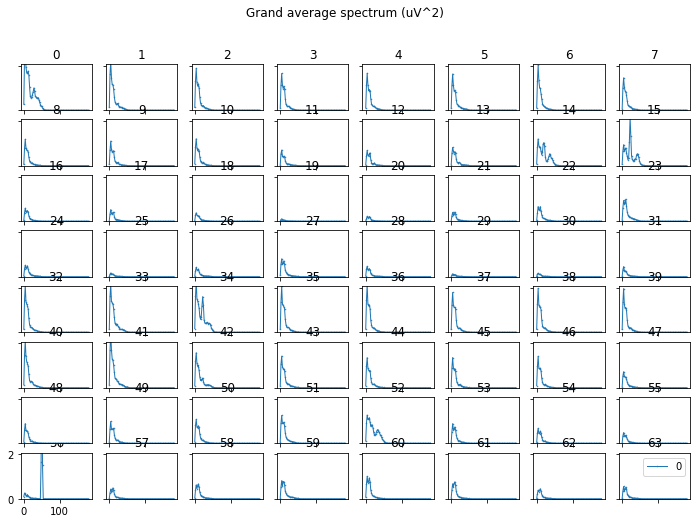

In [49]:
from mindaffectBCI.decoder.preprocess import plot_grand_average_spectrum
plot_grand_average_spectrum(X, fs=coords[1]['fs'], ch_names=coords[-1]['coords'])

No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(36, 1513, 64)
Y=(36, 1513, 37)
fs=360
Plot X+Y


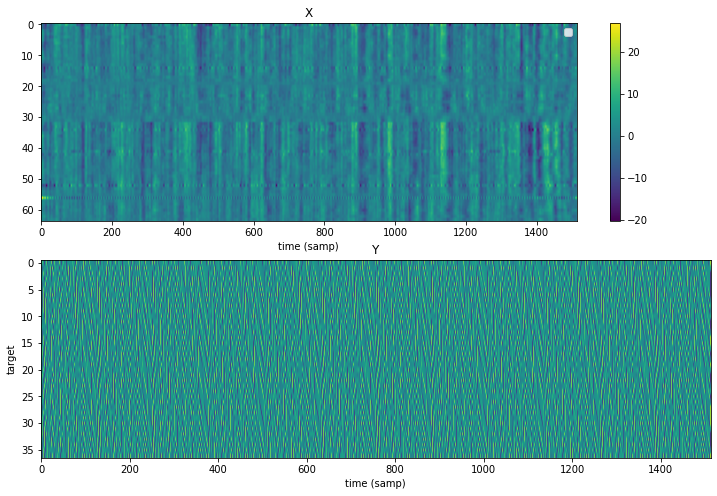

Plot summary stats


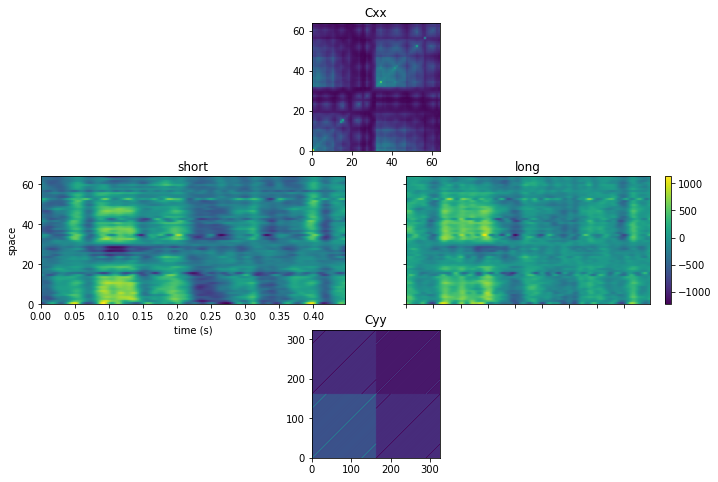

Plot global spectral properties
FX=(36, 91, 64)
erp=(1, 91, 64)


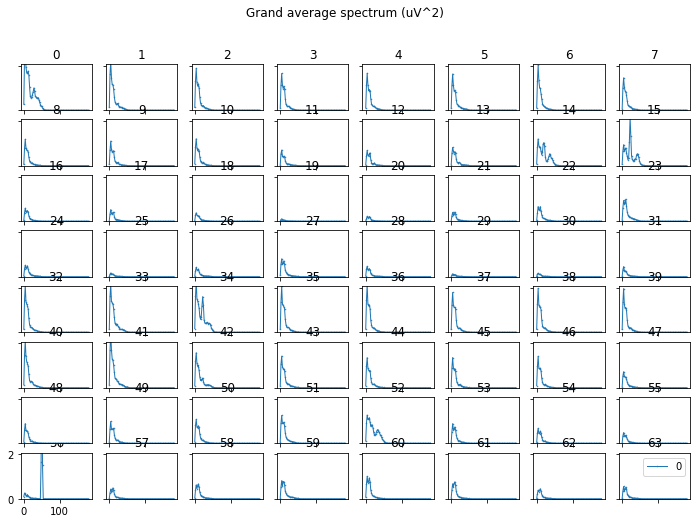

Plot ERP
erp=(2, 162, 64)


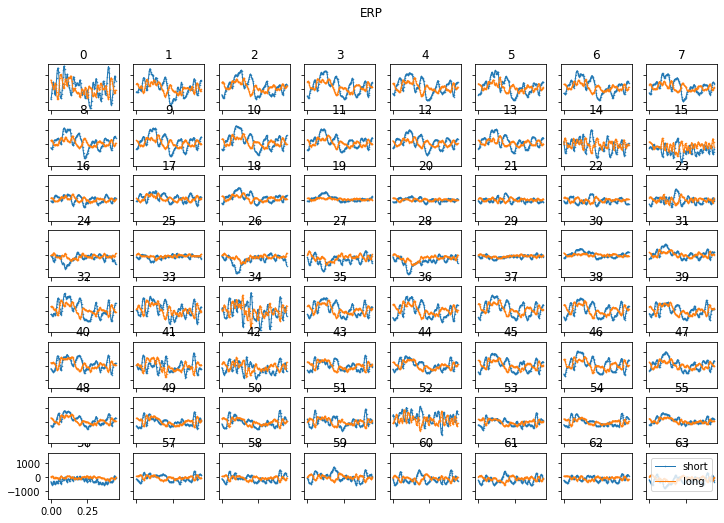

X(['trial', 'time', 'channel'])=(36, 1513, 64), Y=(36, 1513, 37) @360hz
Cscale=3.9780361652374268
Sigma0 = 0.20058723501670128
softmaxscale=1
MultiCCA(badEpThresh=3, evtlabs=('short', 'long'), rank=3, tau=162)
score=0.024454725710508923
Int Lens:..............................

            IntLen   201   403   554   756   958  1109  1311  1513 
              Perr  0.92  0.92  0.92  0.97  0.94  0.97  1.00  1.00   AUDC 96.7
         Perr(est)  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96   PSAE  2.9
           StopErr  1.00  1.00  1.00  1.00  1.00  1.00  0.97  1.00   AUSC 99.5
     StopThresh(P)  0.96  0.96  0.96  0.96  0.95  0.95  0.95  0.96   SSAE  4.0

Plot Model
erp=(2, 162, 64)


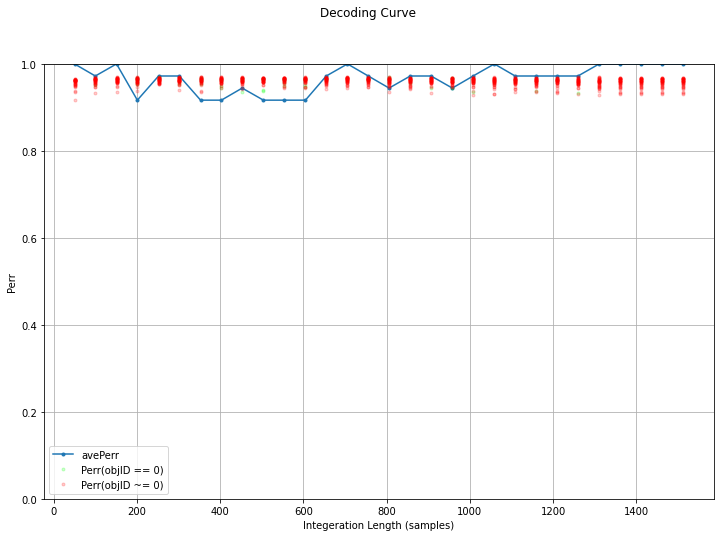

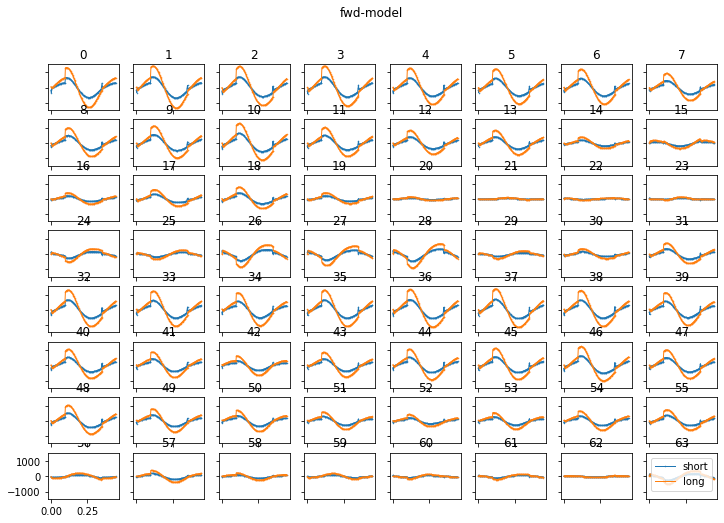

Plot Factored Model
Plot Factored Model
A=(3, 64) R=(3, 2, 162)


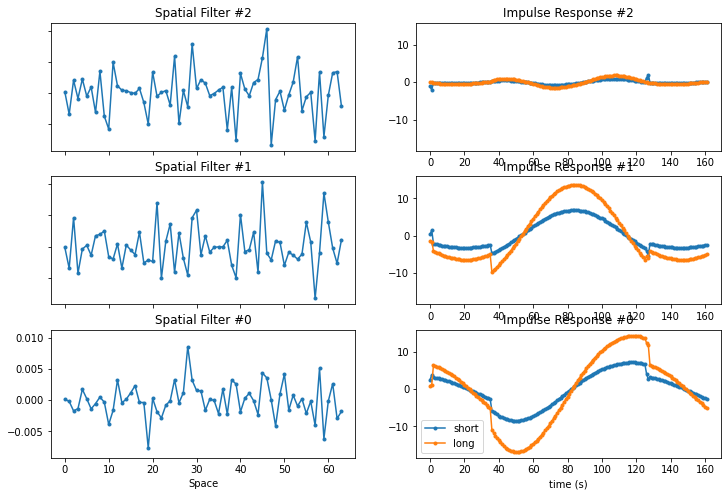

plot Fe


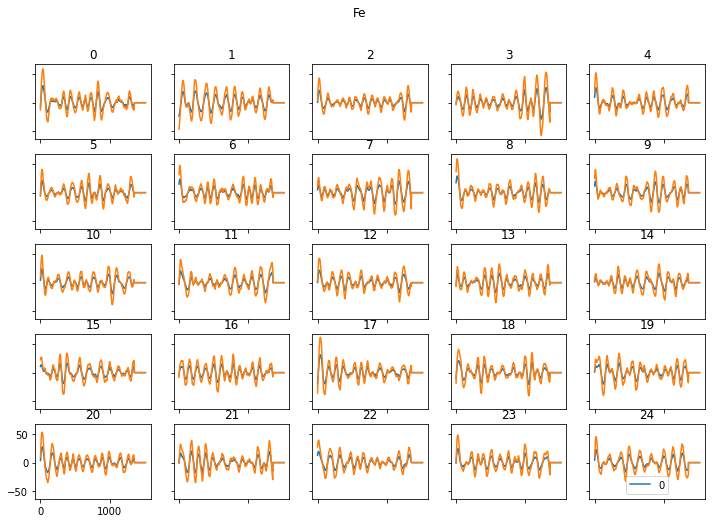

plot Fy


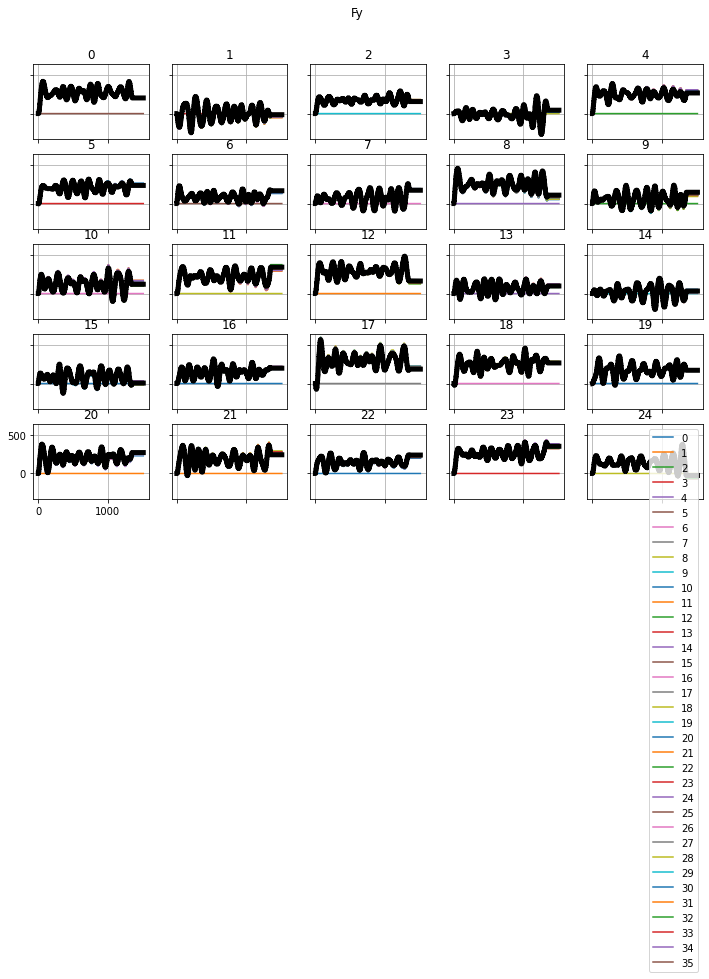

normalized Fy


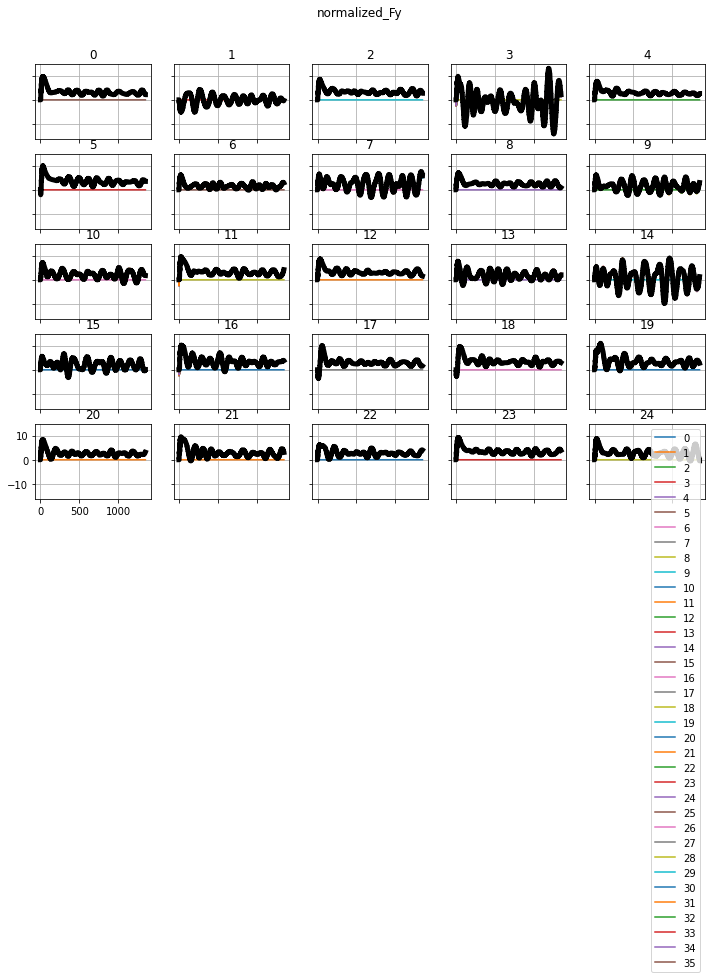

sFy=(1513, 37)


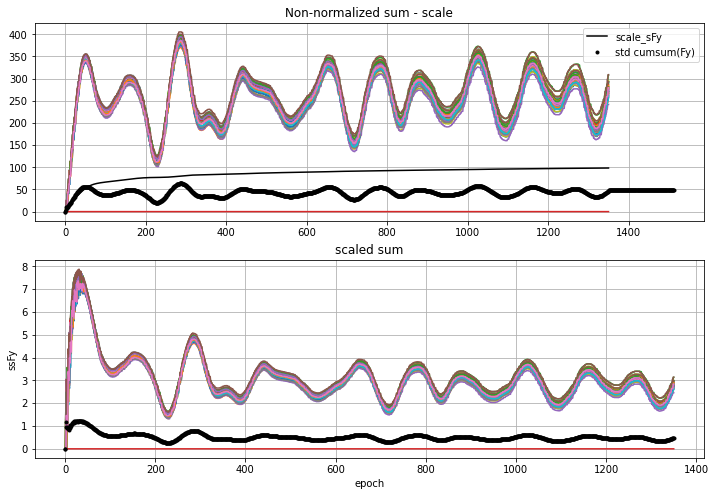

In [53]:
clsfr=debug_test_dataset(X, Y, coords,
                         preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, stopband=None, whiten_spectrum=False),
                         model='cca', evtlabs=('short', 'long'), rank=3, tau_ms=450, badEpThresh=3)

## Evaluate prediction error on test set as number of trials (or epochs?) in train set grows

* 36 trials in train set, so we can make the trial incremement equal to 1
* For each value in 1:36 of n_trials, perform CCA by calling model.fit(), and then call model.predict() on the test data
* Go back and look at the Kernel document, to try to reproduce exactly their plots, avoiding any decoding curve weirdness if possible

Analyse the data
--
The following code runs the standard initial analysis and data-set visualization, in one go with some standard analysis parameters:
 * tau_ms : the length of the modelled stimulus response   (in milliseconds)
 * evtlabs : the type of brain feaatures to transform the stimulus information into prior to fitting the model in this case 
     * 're' -> rising edge    
     * 'fe' -> falling edge
   see `stim2event.py` for  more   information on possible transformations
 * rank  : the rank of  the CCA model to fit
 * model : the type of model to fit. 'cca' corrospends to the Cannonical Correlation Analysis model.
           other options include: 
           * 'ridge' = ridge-regression, 
           * 'fwd' = Forward Modelling, 
           * 'bwd' = Backward Modelling, 
           * 'lr' = logistic-regression, 
           * 'svc' = support vector machine
   see `model_fitting.py` for how to add more models

This generates 6 visualizations:

 1.  *X+Y* : raw plot of  the 1st trials EEG and STIMULUS information

 2.  *Summary Statistics*: Summary statistics for the data with, 
      row 1:   Cxx : the covariance of the the EEG channel features
      row 2:   Cxy : the cross covariance of the EEG with each of the stimulus features, e.g. 're', 'fe'
      row 3:   Cyy : the auto-cross covariance of the stimulus features with the other (time-delayed) stimulus features

 3. *ERP* : plot of the average response for each stimulus feature over EEG  channels

 4. *Decoding Curve* : The decoder accumulates information during a trial to make it's predictions better. This plot shows the error of this accumulated prediction as a function of number of samples since trial start

 5. *Model*: plot of the fitted model, as a feature weighting over time-points and EEG channels

 6. *Fe* : Applying the model generates a *predicted* stimulus-feature "score" for each EEG time point. Where a higher score means the model thinks that stimulus-feature is more likely at this time point. This plot shows these scores for a sub-set of the trials.

 7. *Fy* : Combining Fe (the predicted stimulus),  with Y (the true-stimulus) and summing from the trial-start gives a score for each possible output, where again the higher score  indicates the model thinks this output is the more likely to be the *true* target.  
 This plot shows these accumulated scores for each output, *with the true output* draw with a thicker black line.  Thus, for a good model you should see that black line is the highest for most/all trials.


No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(20, 564, 10)
Y=(20, 564, 26)
fs=90.92479502664156
Plot X+Y


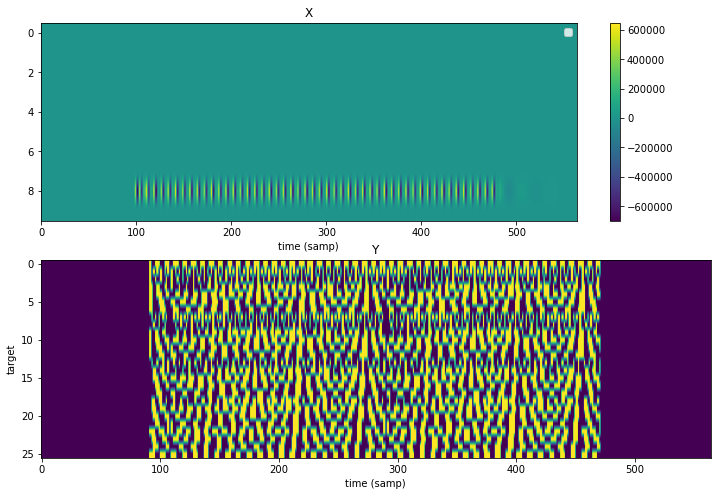

Plot summary stats


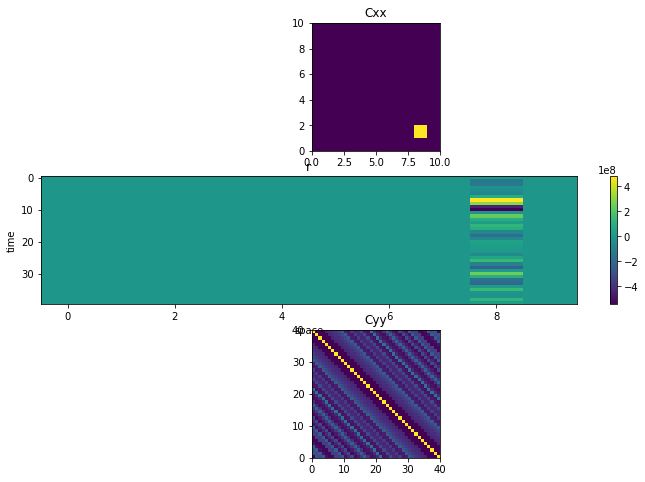

Plot global spectral properties
FX=(20, 23, 10)
erp=(1, 23, 10)


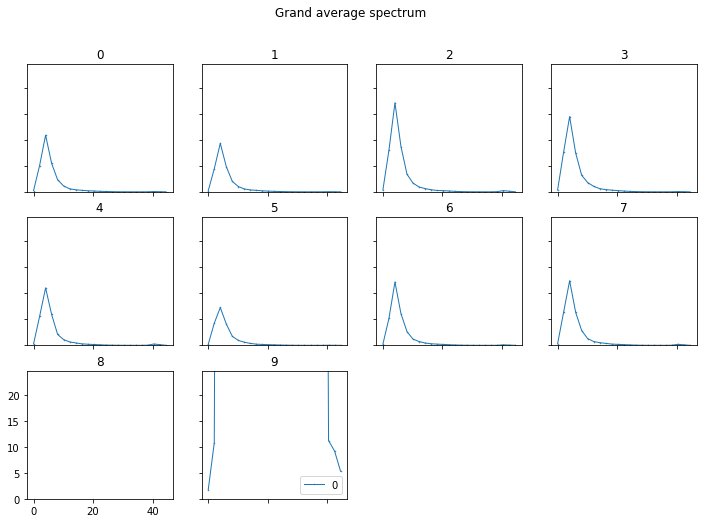

Plot ERP
erp=(1, 40, 10)


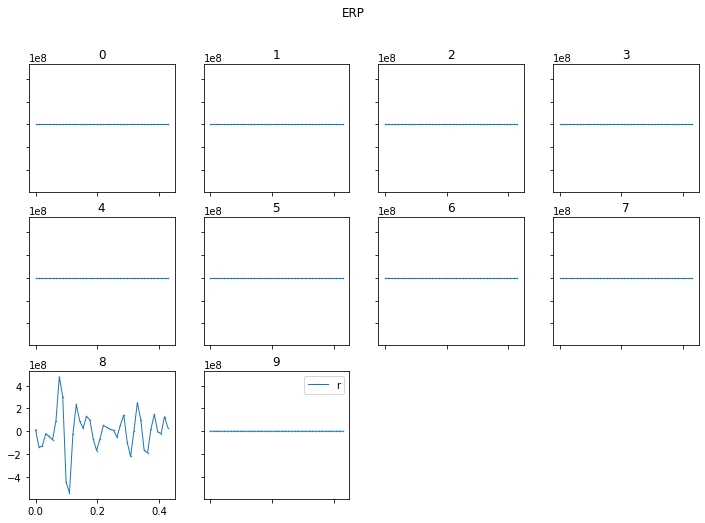

X(['trial', 'time', 'channel'])=(20, 564, 10), Y=(20, 564, 26) @90.92479502664156hz
Cscale=92223.61797552589
Sigma0() = 0.06613346828435354
MultiCCA(CCA=True, badEpThresh=3, center=True, evtlabs='re', offset=0, rank=3,
         rcond=None, reg=0.02, symetric=False, tau=40)
score=0.9976950354609929
Int Lens:..............................

            IntLen    75   150   206   282   357   413   488   564 
              Perr  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUDC 15.8
         Perr(est)  1.00  0.23  0.06  0.06  0.05  0.05  0.05  0.05   PSAE 98.9
           StopErr  0.95  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUSC 15.8
     StopThresh(P)  0.92  0.25  0.14  0.07  0.07  0.07  0.07  0.07   SSAE 113.6

Plot Model
erp=(1, 40, 10)


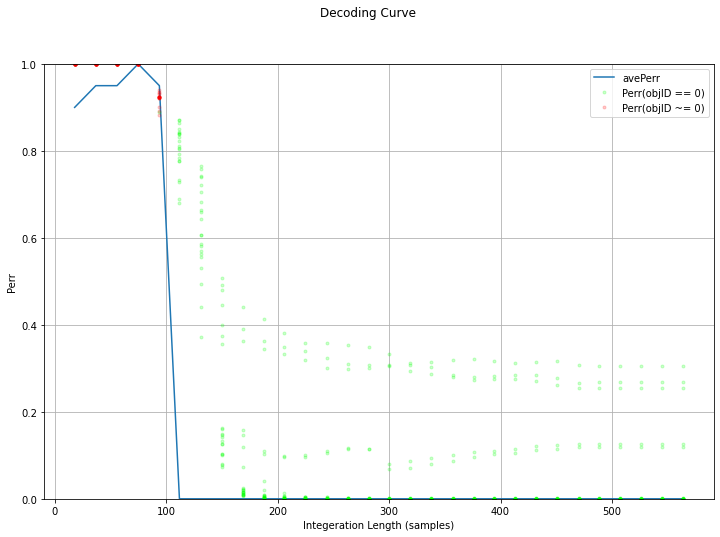

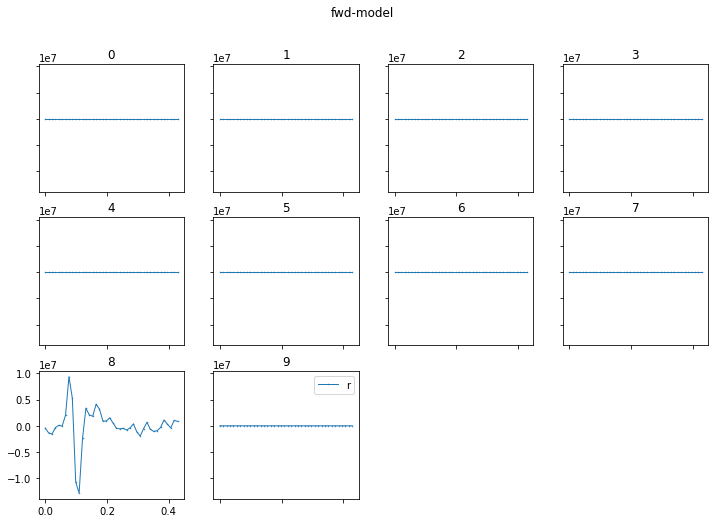

Plot Factored Model
trying to get pos from cap file!
A=(3, 10) R=(3, 1, 40)


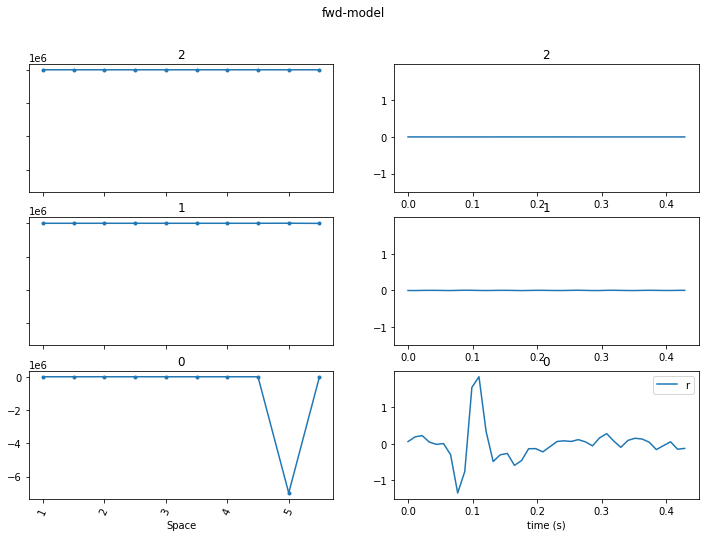

plot Fe


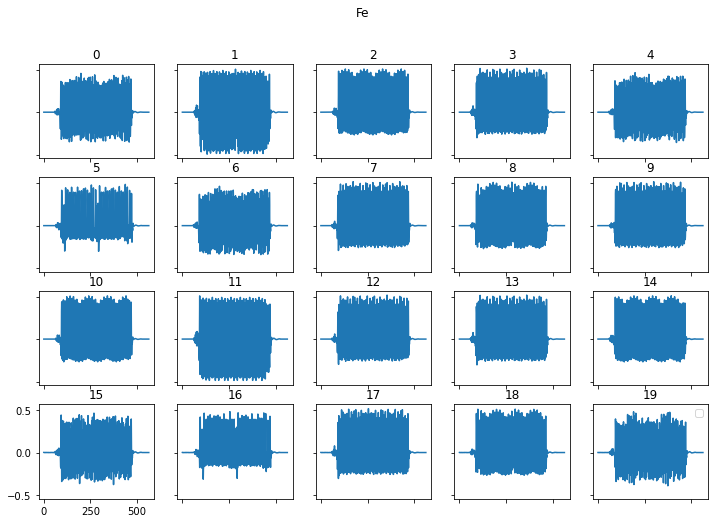

plot Fy


In [ ]:
clsfr=debug_test_dataset(X, Y, coords,
                         preproc_args=dict(badChannelThresh=None, badTrialThresh=None, stopband=None, whiten_spectrum=False),
                         model='cca', evtlabs=('re'), rank=3, tau_ms=450, badEpThresh=3)

No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(13, 518, 8)
Y=(13, 518, 5)
fs=83.53227594469631
Bad Channels Removed: 0 = []
whiten:0.01
Spectral whiten:0.1
Plot X+Y


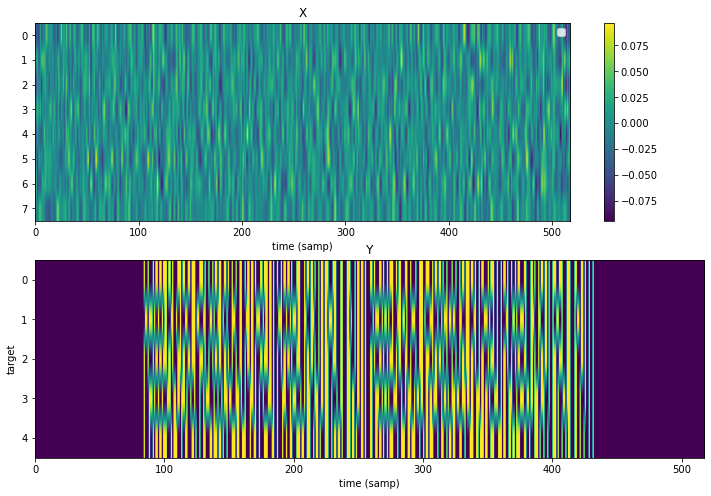

Plot summary stats


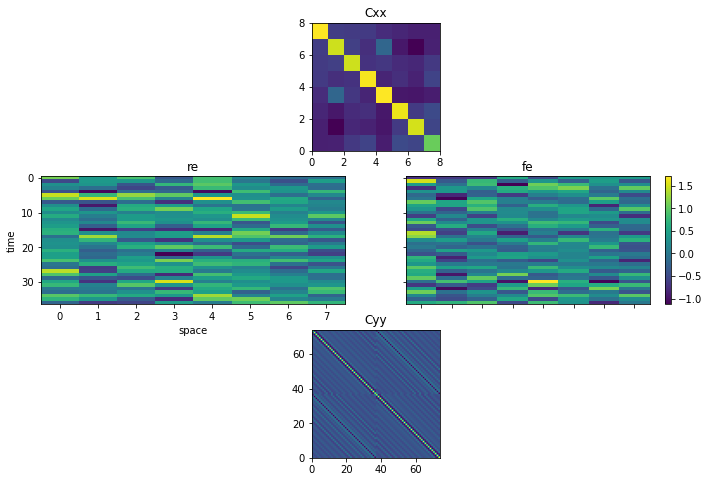

Plot global spectral properties
FX=(13, 21, 8)
erp=(1, 21, 8)


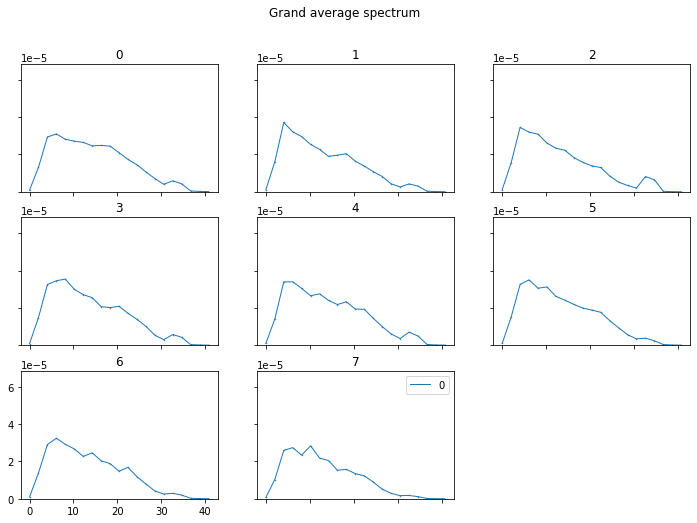

Plot ERP
erp=(2, 37, 8)


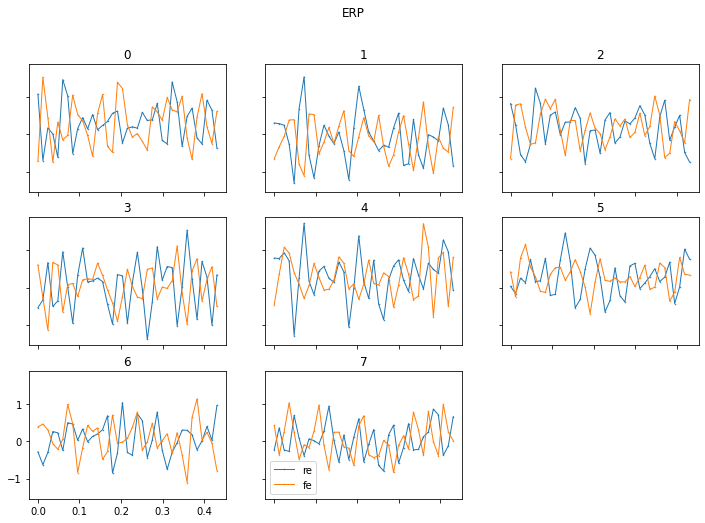

X(['trial', 'time', 'channel'])=(13, 518, 8), Y=(13, 518, 5) @83.53227594469631hz
Cscale=0.025593716492600956
Sigma0() = 0.09641182789864605
LinearSklearn(badEpThresh=3,
              clsfr=LogisticRegression(C=3.9072090225313554, class_weight=None,
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None,
                                       max_iter=100, multi_class='auto',
                                       n_jobs=None, penalty='l2',
                                       random_state=None, solver='lbfgs',
                                       tol=0.0001, verbose=0,
                                       warm_start=False),
              ignore_unlabelled=True, labelizeY=True)
score=0.425007425007425
Discarded 3 trials without true-label info
Int Lens:..............................

            IntLen    69   138   189   259   328   379   448   518 
              Perr  0.90  0.70  0.60  0.7

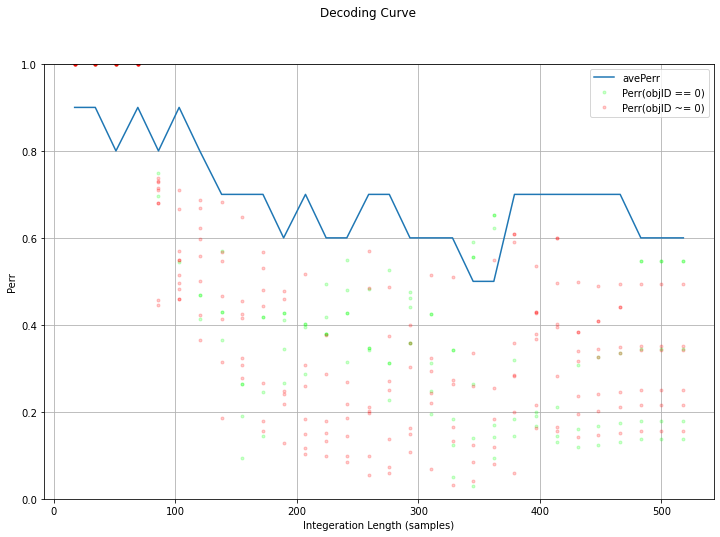

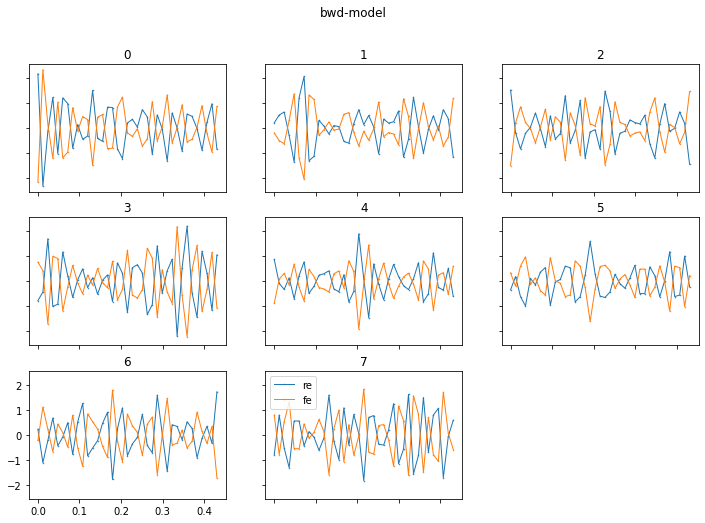

plot Fe


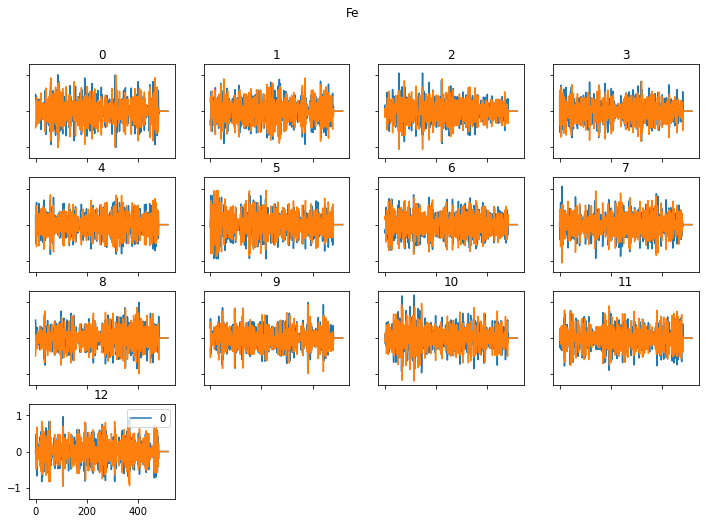

plot Fy


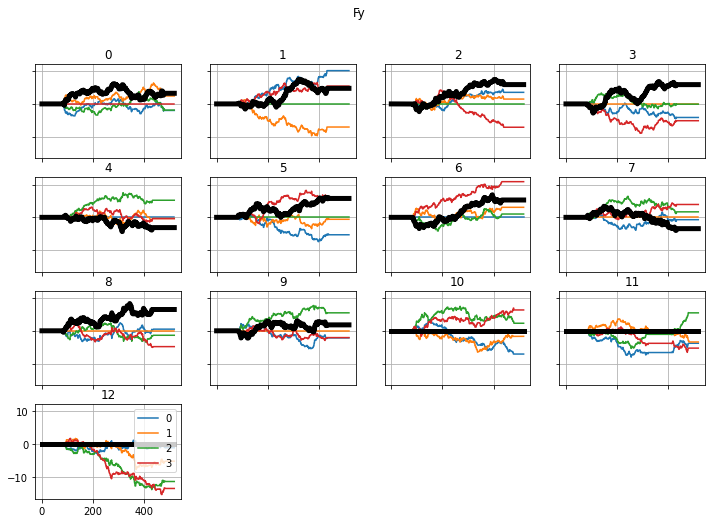

normalized Fy


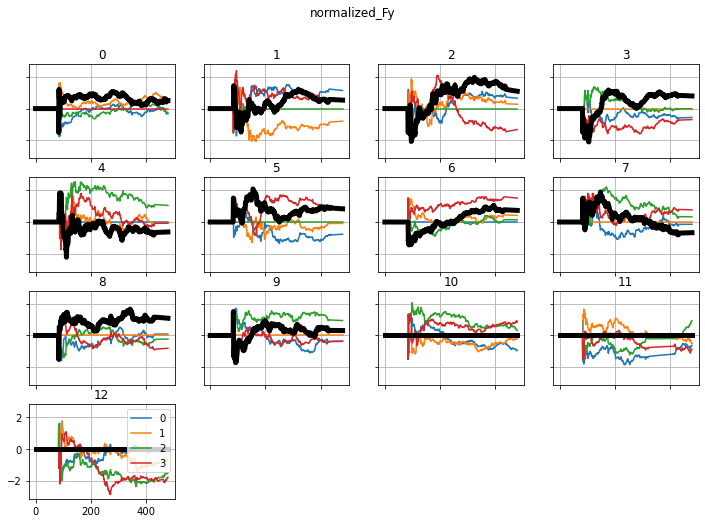

sFy=(518, 5)


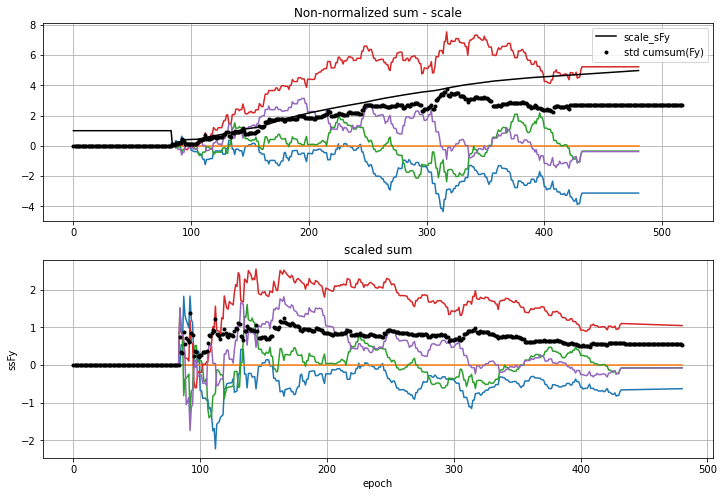

LinearSklearn(badEpThresh=3,
              clsfr=LogisticRegression(C=3.9072090225313554, class_weight=None,
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None,
                                       max_iter=100, multi_class='auto',
                                       n_jobs=None, penalty='l2',
                                       random_state=None, solver='lbfgs',
                                       tol=0.0001, verbose=0,
                                       warm_start=False),
              ignore_unlabelled=True, labelizeY=True)

In [92]:
# test different inner classifier
debug_test_dataset(X, Y, coords,
                   preproc_args=dict(badChannelThresh=3, badTrialThresh=None, whiten=.01, whiten_spectrum=.1),
                   model='lr', evtlabs=('re', 'fe'), rank=1, tau_ms=450, badEpThresh=3, ignore_unlabelled=True)

No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(13, 518, 8)
Y=(13, 518, 5)
fs=83.53227594469631
Bad Channels Removed: 0 = []
whiten:True
Plot X+Y


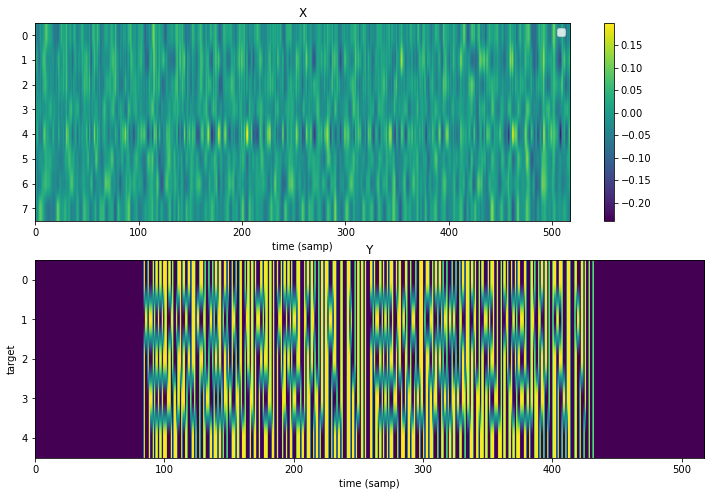

Plot summary stats


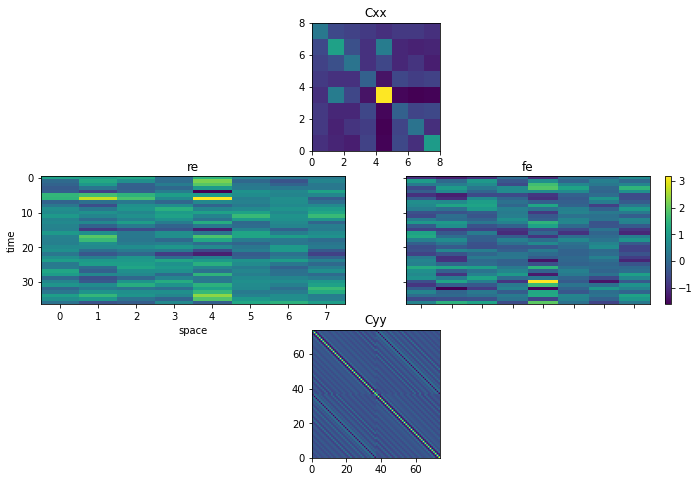

Plot global spectral properties
FX=(13, 21, 8)
erp=(1, 21, 8)


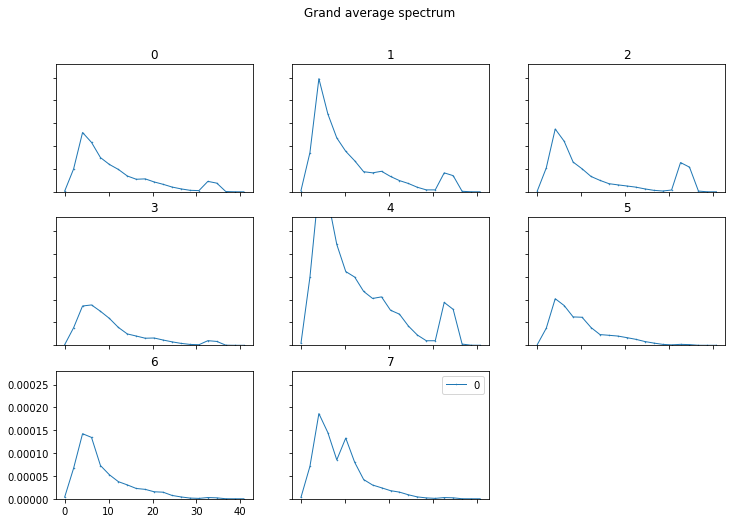

Plot ERP
erp=(2, 37, 8)


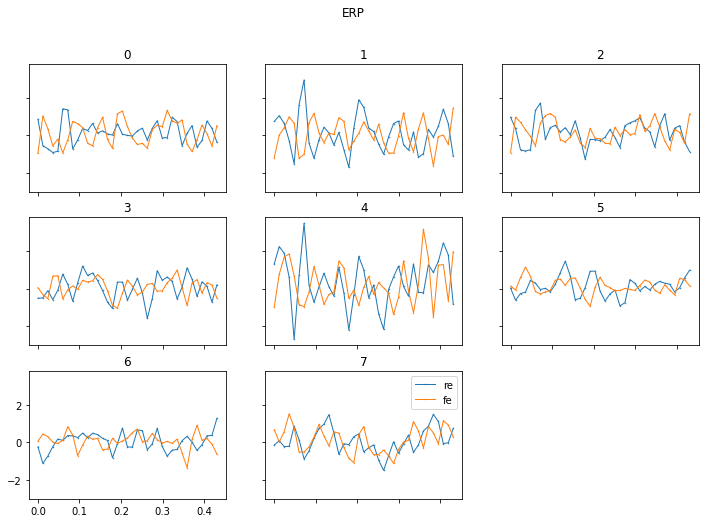

X(['trial', 'time', 'channel'])=(13, 518, 8), Y=(13, 518, 5) @83.53227594469631hz
Cscale=0.04393747751637469


c:\users\developer\desktop\pymindaffectbci\mindaffectBCI\decoder\updateSummaryStatistics.py:314: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if X.shape[0] < 100 and np.issubdtype(X.dtype, np.float) and np.issubdtype(Y.dtype, np.float): # all at once


Sigma0() = 0.007173522613948373
BwdLinearRegression(badEpThresh=3, center=True, evtlabs=('re', 'fe'), offset=0,
                    rcond=1e-05, reg=None, tau=37)
score=0.4674784674784675
Discarded 3 trials without true-label info
Int Lens:..............................

            IntLen    69   138   189   259   328   379   448   518 
              Perr  0.80  0.90  0.40  0.70  0.40  0.50  0.50  0.40   AUDC 56.7
         Perr(est)  1.00  0.42  0.34  0.33  0.40  0.37  0.34  0.36   PSAE 24.4
           StopErr  0.60  0.70  0.60  0.40  0.40  0.40  0.40  0.40   AUSC 51.0
     StopThresh(P)  0.71  0.38  0.28  0.22  0.22  0.27  0.27  0.36   SSAE 36.0

Plot Model
erp=(2, 37, 8)


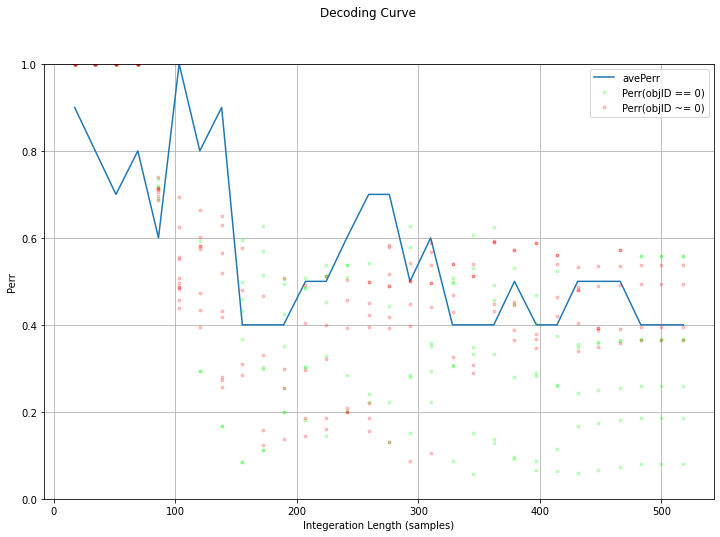

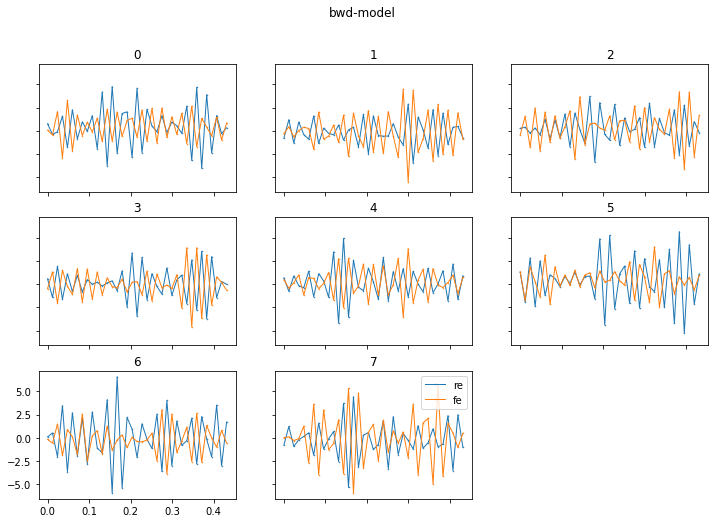

plot Fe


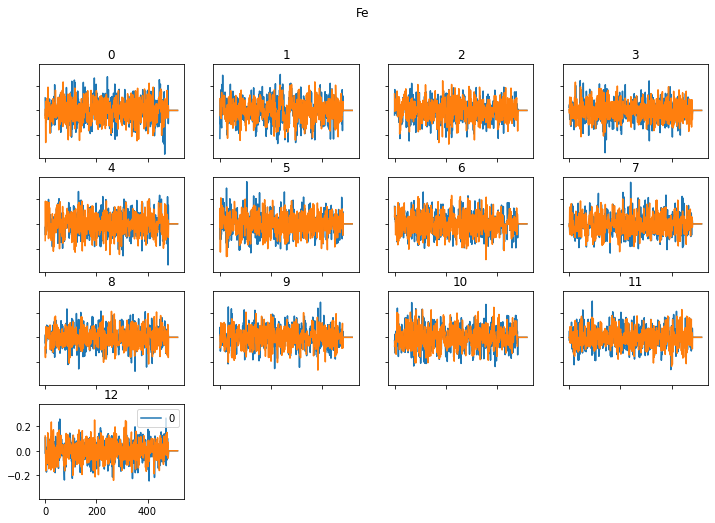

plot Fy


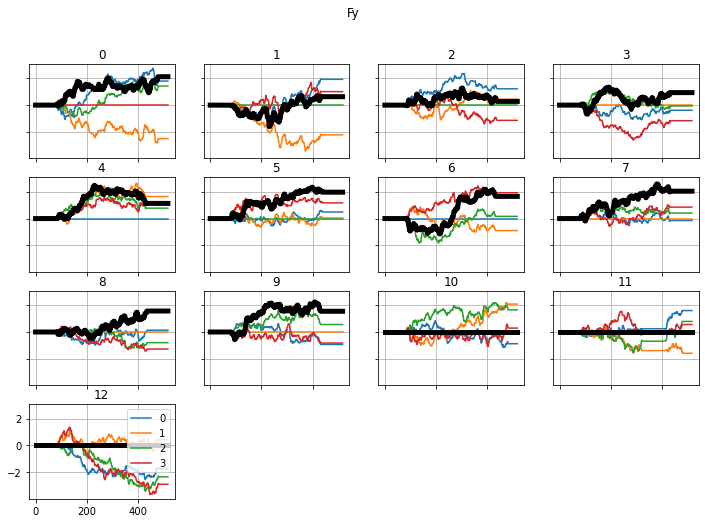

normalized Fy


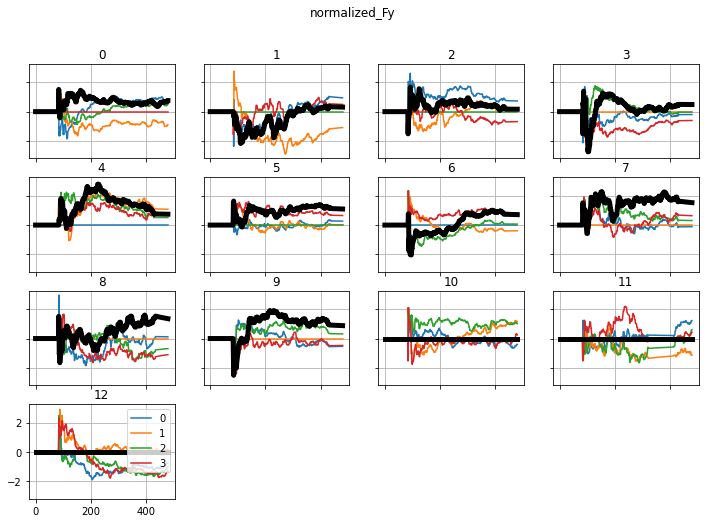

sFy=(518, 5)


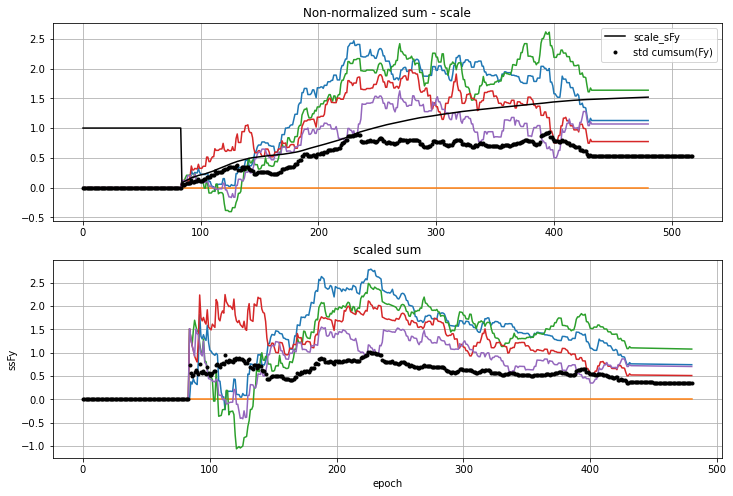

BwdLinearRegression(badEpThresh=3, center=True, evtlabs=('re', 'fe'), offset=0,
                    rcond=1e-05, reg=None, tau=37)

In [94]:
# test different inner classifier
debug_test_dataset(X, Y, coords,
                   preproc_args=dict(badChannelThresh=3, badTrialThresh=None, whiten=True, whiten_spectrum=.01),
                   model='bwd', evtlabs=('re', 'fe'), tau_ms=450, badEpThresh=3)

No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(13, 518, 8)
Y=(13, 518, 5)
fs=83.53227594469631
Bad Channels Removed: 0 = []
whiten:True
Spectral whiten:0.1
Plot X+Y


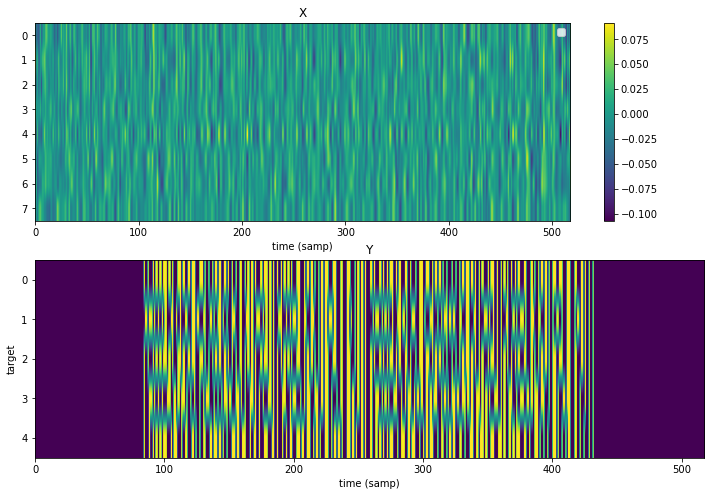

Plot summary stats


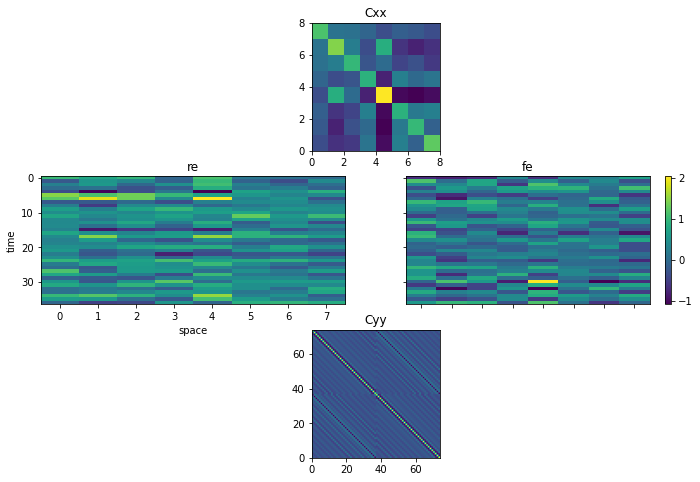

Plot global spectral properties
FX=(13, 21, 8)
erp=(1, 21, 8)


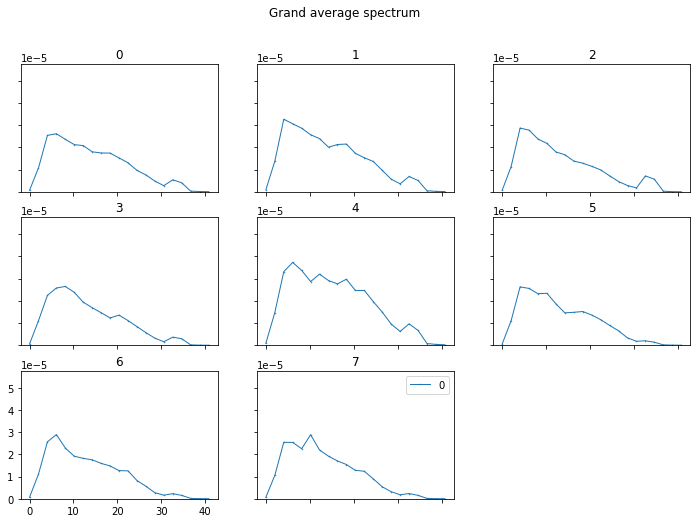

Plot ERP
erp=(2, 37, 8)


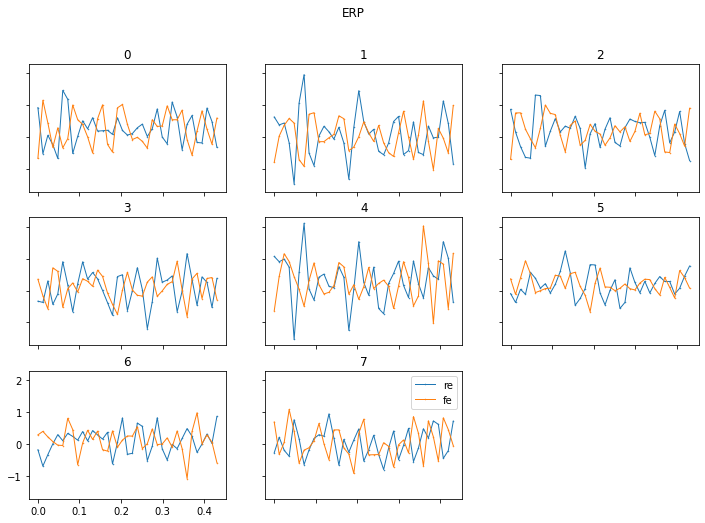

X(['trial', 'time', 'channel'])=(13, 518, 8), Y=(13, 518, 5) @83.53227594469631hz
Cscale=0.023829674527713497
Sigma0() = 0.006097916085961004
LinearSklearn(badEpThresh=3,
              clsfr=Ridge(alpha=0, copy_X=True, fit_intercept=True,
                          max_iter=None, normalize=False, random_state=None,
                          solver='auto', tol=0.001),
              ignore_unlabelled=True, labelizeY=False)
score=0.46926046926046927
Discarded 3 trials without true-label info
Int Lens:..............................

            IntLen    69   138   189   259   328   379   448   518 
              Perr  0.70  0.80  0.60  0.70  0.50  0.50  0.50  0.40   AUDC 59.7
         Perr(est)  1.00  0.39  0.30  0.33  0.41  0.37  0.37  0.38   PSAE 31.9
           StopErr  0.80  0.70  0.40  0.40  0.40  0.40  0.40  0.40   AUSC 52.7
     StopThresh(P)  0.71  0.32  0.21  0.23  0.23  0.29  0.29  0.36   SSAE 32.9

Plot Model
erp=(2, 37, 8)


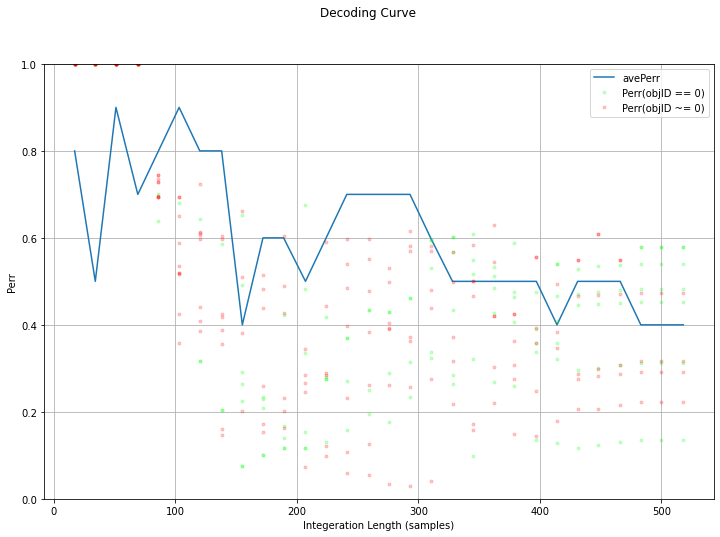

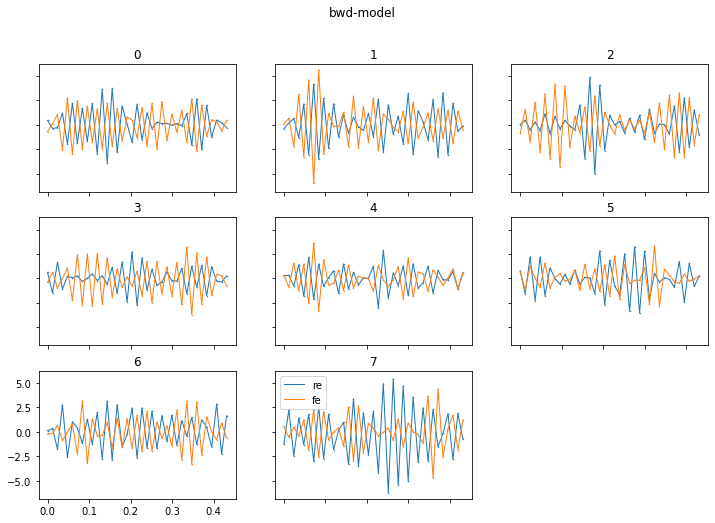

plot Fe


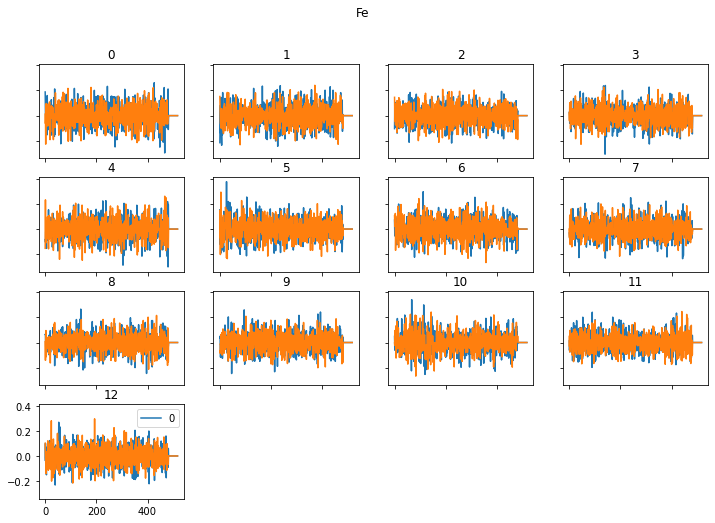

plot Fy


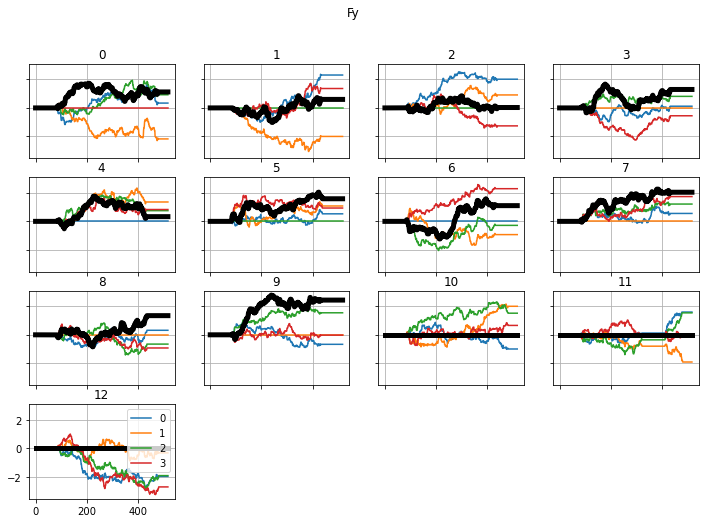

normalized Fy


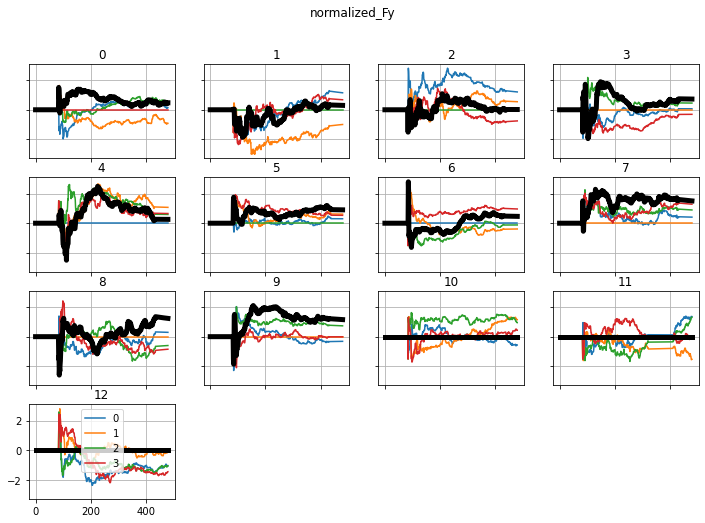

sFy=(518, 5)


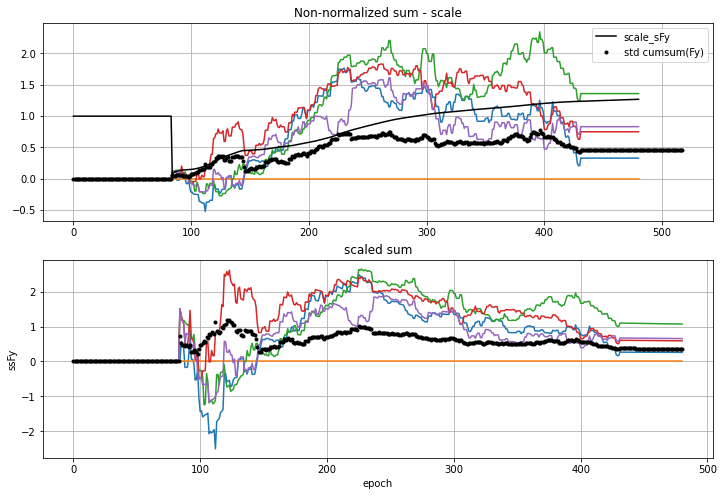

LinearSklearn(badEpThresh=3,
              clsfr=Ridge(alpha=0, copy_X=True, fit_intercept=True,
                          max_iter=None, normalize=False, random_state=None,
                          solver='auto', tol=0.001),
              ignore_unlabelled=True, labelizeY=False)

In [93]:
# test different inner classifier
debug_test_dataset(X, Y, coords,
                   preproc_args=dict(badChannelThresh=3, badTrialThresh=None, whiten=True, whiten_spectrum=.1),
                   model='ridge', evtlabs=('re', 'fe'), tau_ms=450, badEpThresh=3)

FileUpload(value={}, description='Upload')

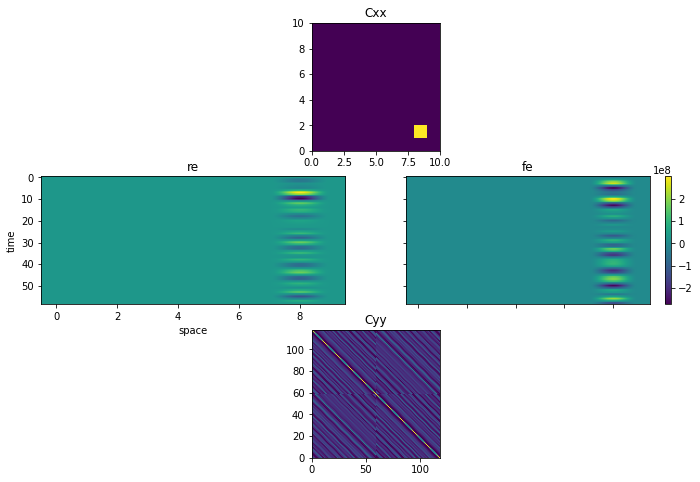

In [31]:
from mindaffectBCI.decoder.updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics
# manual summary statistics compute and plot
Y_true = clsfr.stim2event(Y)
Y_true = Y_true[...,0:1,:]
Cxx, Cxy, Cyy = updateSummaryStatistics(X,Y_true,tau=clsfr.tau)
plot_summary_statistics(Cxx,Cxy,Cyy,clsfr.evtlabs)

[3.08983677e+04 2.80017881e+04 5.08857607e+04 4.60784201e+04
 3.25990504e+04 2.41176705e+04 3.45901436e+04 3.68575593e+04
 4.79671332e+13 2.17026414e+09]
[9.59342665e+13 4.34039997e+09 2.06205843e+04 1.15013881e+05
 9.84664398e+04 5.03648744e+04 6.02050345e+04 7.97241151e+04
 7.49039116e+04 6.87062870e+04]


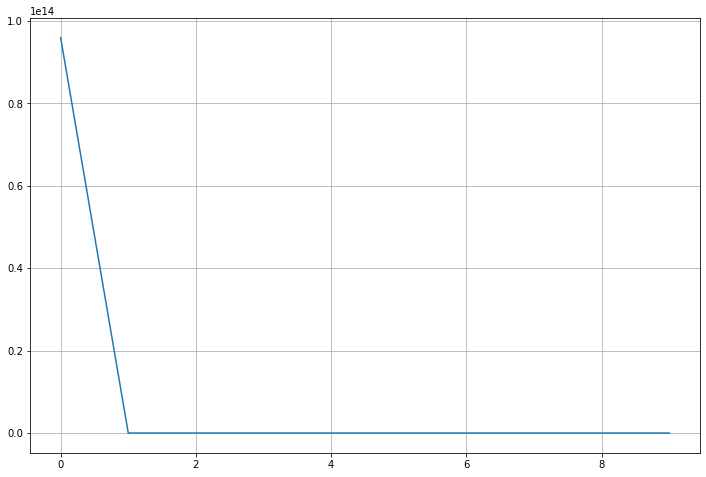

rcond=0.0001
sigma\[4.79584992e+13 3.12915202e+09 9.59396383e+08 9.59443570e+08
 9.59435298e+08 9.59411252e+08 9.59416171e+08 9.59425929e+08
 9.59423519e+08 9.59420421e+08]
bad=[False False False False False False False False False False]
bad=[False  True  True  True  True  True  True  True  True  True]


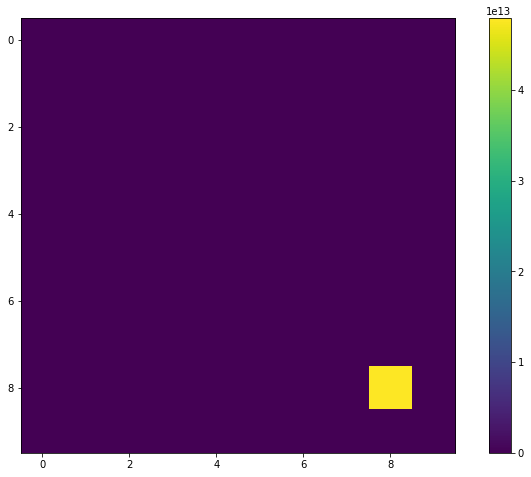

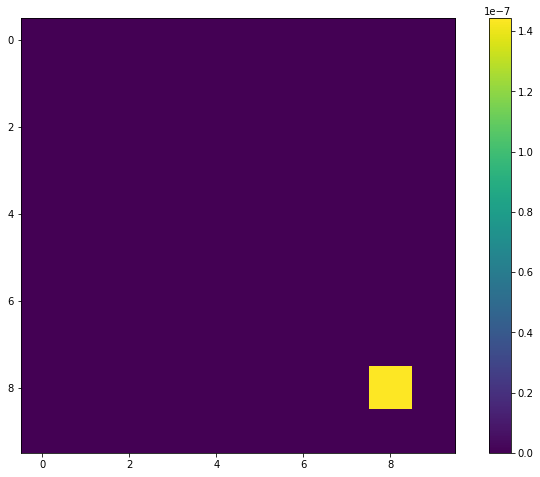

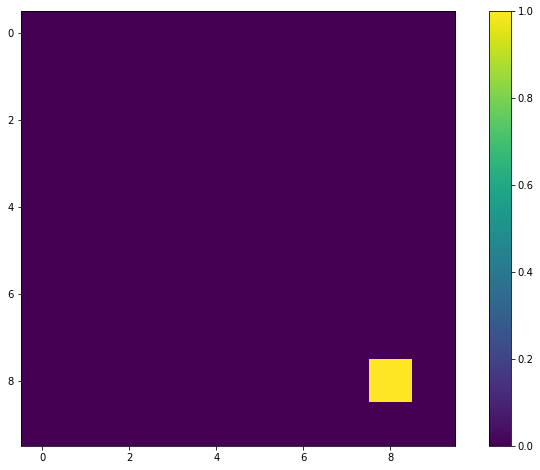

In [99]:
from mindaffectBCI.decoder.multipleCCA import robust_whitener
A = Cxx#[:-1,:-1]; #Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1))
print(np.diag(Cxx))
s,U = np.linalg.eig(A+A.T)
print(s)
plt.plot(s);plt.grid();plt.show()
wA,iwA = robust_whitener(A,reg=.0002,rcond=1e-4)
plt.imshow(A);plt.colorbar();plt.show()
plt.imshow(wA);plt.colorbar();plt.show()
plt.imshow(wA@A@wA);plt.colorbar();

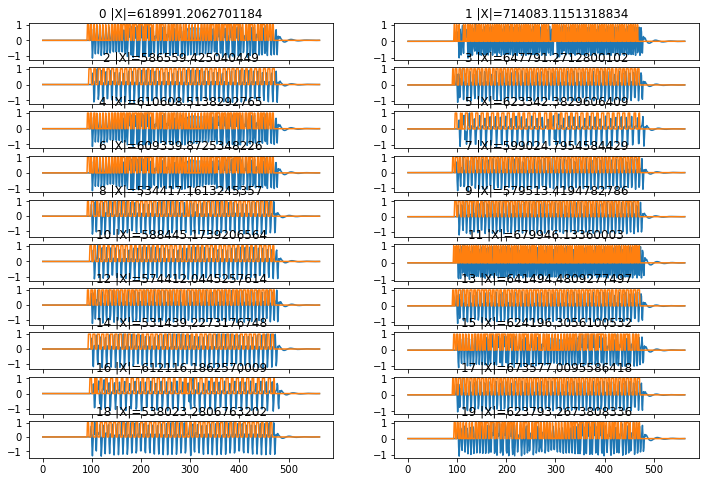

In [104]:
# plot X(9),Y(0)
N = X.shape[0]
for i in range(N):
    plt.subplot(N/2,2,i+1)
    plt.plot(X[i,:,8]/np.max(X[i,:,8]),label="X")
    plt.plot(Y[i,:,0],label="Y")
    plt.title('{} |X|={}'.format(i,np.max(X[i,:,8])))